In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import galsim
from IPython.display import clear_output
from astropy.io import fits
from matplotlib.colors import LogNorm
from numpy import mgrid, sum
import scipy.linalg as alg
import scipy.stats as stats
from galsim.zernike import Zernike
import matplotlib

In [36]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [21]:
class shapeletXmoment:
    
    def __init__(self, psf,n, bmax = 10, pixel_scale = 1.0):
        self.n = n
        self.bmax = bmax
        self.pixel_scale = pixel_scale
        self.base_psf = psf
        self.base_psf_image = psf.drawImage(scale = pixel_scale, method = 'no_pixel')
        self.base_psf_result = galsim.hsm.FindAdaptiveMom(self.base_psf_image)
        self.base_shapelet = galsim.Shapelet.fit(self.base_psf_result.moments_sigma, bmax, self.base_psf_image, normalization = 'sb')
        self.base_bvec = self.base_shapelet.bvec
        
    def moment_measure(self, image, p, q):
        n = p+q
        
        if n<2:
            print "Does not support moment measure less than second order."
            return 0
        elif n==2:
            return self.get_second_moment(image,p,q)
        else:
            return self.higher_weighted_moment(image,p,q)
        
    def get_second_moment(self, image, p ,q):
        image_results = galsim.hsm.FindAdaptiveMom(image)
        if p==2:
            return image_results.observed_shape.e1
        elif q==2:
            return image_results.observed_shape.e2
        else:
            return image_results.moments_sigma
        
    def higher_weighted_moment(self,gsimage,p,q):
        
        image = gsimage.array
        

        x, y = mgrid[:image.shape[0],:image.shape[1]]+1

        psfresults = galsim.hsm.FindAdaptiveMom(galsim.Image(image, scale = self.pixel_scale))
        M = np.zeros((2,2))
        e1 = psfresults.observed_shape.e1
        e2 = psfresults.observed_shape.e2
        sigma4 = psfresults.moments_sigma**4
        c = (1+e1)/(1-e1)
        M[1][1] = np.sqrt(sigma4/(c-0.25*e2*(1+c)**2))
        M[0][0] = c*M[1][1]
        M[0][1] = 0.5*e2*(M[1][1]+M[0][0])
        M[1][0] = M[0][1]

        pos = np.array([x-psfresults.moments_centroid.x, y-psfresults.moments_centroid.y])
        pos = np.swapaxes(pos,0,1)
        pos = np.swapaxes(pos,1,2)


        inv_M = np.linalg.inv(M)
        sqrt_inv_M = alg.sqrtm(inv_M)
        std_pos = np.zeros(pos.shape)
        weight = np.zeros(pos.shape[0:2])
        for i in range(pos.shape[0]):
            for j in range(pos.shape[1]):
                this_pos = pos[i][j]
                this_standard_pos = np.matmul(sqrt_inv_M, this_pos)
                std_pos[i][j] = this_standard_pos
                weight[i][j] = np.exp(-0.5* this_standard_pos.dot(this_standard_pos))

        std_x, std_y = std_pos[:,:,0],std_pos[:,:,1]

        return sum(std_x**p*std_y**q*weight*image)/sum(image*weight)
    
    
    def modify_pq(self, m, c, delta = 0.0001):
        
        n = self.n
        mu = self.get_mu(n)
        pq_list = self.get_pq_full(n)
        shapelet_list = self.pq2shapelet(pq_list)

        ori_moments = self.get_all_moments(self.base_psf_image, pq_list)
        
        A = np.zeros(shape =(mu, mu))
        
        #i is the mode index
        #j is the moment index
        #measure d_moment_j / d_mode_i
        
        for i in range(mu):
            
            mode_index = shapelet_list[i]
            
            pert_bvec = self.base_bvec.copy()
            pert_bvec[mode_index]+=delta
            ith_pert = galsim.Shapelet(self.base_psf_result.moments_sigma, self.bmax, pert_bvec)
            pert_moment = self.get_all_moments(ith_pert.drawImage(scale = self.pixel_scale,method = 'no_pixel'), pq_list)
            for j in range(mu):
                A[i][j] = (pert_moment[j] - ori_moments[j])/delta     
        self.A = A


        dm = np.zeros(mu)
        dm += m*ori_moments + c
        ds = np.linalg.solve(A.T,dm)
        #print ds
        #print dm
        
        true_mod_bvec = self.base_bvec.copy()
        for i in range(mu):
            true_mod_bvec[shapelet_list[i]]+=ds[i]

        
        self.true_mod = galsim.Shapelet(self.base_psf_result.moments_sigma,  self.bmax, true_mod_bvec)
        return self.true_mod
            

                
    def get_all_moments(self, image, pq_list):
        results_list = []
        for tup in pq_list:
            results_list.append(self.moment_measure(image, tup[0], tup[1]))
                
        return np.array(results_list)
        
        
    def pq2mode(self,p,q):
        
        if p<=q:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)
        else:
            return (p+q)*(p+q+1)//2 + 2*min(p,q)+1
        
        
        
    def pq2shapelet(self,pq_list):
        shapelet_index = []
        for tup in pq_list:
            shapelet_index.append(self.pq2mode(tup[0], tup[1]))
        return shapelet_index
        
        
        

        
        
    def get_mu(self, n):
        
        mu = 0
        for i in range(2,n+1):
            mu+=i+1
        return mu
    
    def get_pq_full(self,nmax):
        
        pq_list = []
        
        for n in range(2, nmax+1):
            p = 0
            q = n
            
            pq_list.append((p,q))
            
            while p<n:
                p+=1
                q-=1
                pq_list.append((p,q))
        return pq_list
    
    def get_pq_except(self,nmax,p,q):
        
        pq_full = self.get_pq_full(nmax)
        pq_except = []
        for tup in pq_full:
            if tup != (p,q):
                pq_except.append(tup)
                
        return pq_except
     
        

In [18]:

class HOMExShapelet:
    
    def __init__(self, gal_type, gal_sigma, e1, e2, psf_type, psf_sigma,
                gal_flux=1.e2,pixel_scale = 1.0,sersicn = -1,subtract_intersection = True,is_self_defined_PSF = False ,
                self_defined_PSF=None, self_define_PSF_model = None, metacal_method = None, GREAT3 = False, 
                cosmic_shear = None, great3_ind = None, great3_cat = None, hsm_core = 'REGAUSS', bpd_params = None):
        
        #Define basic variables
        self.pixel_scale = pixel_scale        
        self.subtract_intersection = subtract_intersection        
        self.is_self_defined_PSF = is_self_defined_PSF
        self.metacal_method = metacal_method

        
        #Define galaxy
        self.gal_type = gal_type
        self.gal_sigma = gal_sigma
        self.gal_flux=gal_flux
        self.e1 = e1
        self.e2 = e2
        self.sersicn=sersicn
        self.e_truth = np.array([e1,e2])
        self.hsm_core = hsm_core


#         if gal_type == "gaussian":
#             self.gal_light = galsim.Gaussian(flux = self.gal_flux, sigma = Gaussian_sigma(self.gal_sigma,self.pixel_scale))
#         elif gal_type == "sersic":
#             self.gal_light = self.findAdaptiveSersic(gal_sigma,sersicn)
        if gal_type == 'gaussian':
            gaussian_profile = galsim.Gaussian(sigma = 1.0)
            gaussian_profile = self.toSize(gaussian_profile, self.gal_sigma,weighted = True)
            self.gal_light = gaussian_profile.withFlux(self.gal_flux)
            self.gal_light = self.gal_light.shear(e1=e1, e2=e2)
        elif gal_type == 'sersic':
            sersic_profile = galsim.Sersic(sersicn, half_light_radius = 1.0)
            sersic_profile = self.toSize(sersic_profile, self.gal_sigma,weighted = True)
            self.gal_light = sersic_profile.withFlux(self.gal_flux)
            self.gal_light = self.gal_light.shear(e1=e1, e2=e2)

        elif gal_type == 'bpd':
            bulge = galsim.Sersic(4, half_light_radius = self.bpd_params[0])
            bulge = bulge.shear(e1 = bpd_params[1], e2 = bpd_params[2])
            disk = galsim.Sersic(1, half_light_radius = self.bpd_params[3])
            disk = disk.shear(e1 = bpd_params[4], e2 = bpd_params[5])
            bulge_to_total = bpd_params[6]
            self.gal_light = bulge_to_total*bulge + (1-bulge_to_total)*disk


        
        if not is_self_defined_PSF:
            self.psf_type = psf_type
            self.psf_sigma = psf_sigma
            self.psf_model_sigma = psf_sigma

          
            if psf_type == 'gaussian':
                self.psf_base = galsim.Gaussian(flux = 1.0, sigma = self.psf_sigma)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma)
            elif psf_type == 'kolmogorov':
                self.psf_base  = galsim.Kolmogorov(flux = 1.0, half_light_radius = 0.5)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma,weighted = True)
            elif psf_type == 'opticalPSF':
                self.psf_base = galsim.OpticalPSF(1.0,flux = 1.0)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma)
            elif psf_type == 'sersic':
                self.psf_base = galsim.Sersic(psf_sersicn, half_light_radius = 1.0)
                self.psf_base = self.toSize(self.psf_base, self.psf_sigma,weighted = True)
                
                
        else:
            self.psf_type = "self_define"
            truth_image = self_defined_PSF
            truth_psf = galsim.InterpolatedImage(truth_image,scale = pixel_scale)
            truth_measure = galsim.hsm.FindAdaptiveMom(truth_image)
            truth_sigma = truth_measure.moments_sigma

            self.psf_light = truth_psf
            
    def setup_shapelet_psf(self, m, c, n, bmax = 10):
        self.n = n
        self.sxm = shapeletXmoment(self.psf_base,n)
        self.psf_light = self.sxm.base_shapelet
        self.psf_model_light = self.sxm.modify_pq(m, c)
        self.dm = m*self.sxm.get_all_moments(self.sxm.base_psf_image, self.sxm.get_pq_full(n))+c

            
            
    def get_intersection(self,metacal):
        image_epsf = self.psf_light.drawImage(scale=self.pixel_scale)
        final = galsim.Convolve([self.gal_light,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        if metacal == False:
            results = galsim.hsm.EstimateShear(image,image_epsf,shear_est=self.hsm_core)
            if self.hsm_core=='KSB':
                obs_shape = galsim.Shear(g1 = results.corrected_g1, g2 = results.corrected_g2)
                intersection = np.array([obs_shape.e1, obs_shape.e2]) - self.e_truth
            else:
                intersection = np.array([results.corrected_e1, results.corrected_e2])-self.e_truth
            return intersection
        else:
            results = self.perform_metacal(image,image_epsf)
            intersection = np.array([results['g_cal'].e1, results['g_cal'].e2**2]) - self.e_truth
            return intersection

    def get_measurement(self,metacal = False):
        image_epsf = self.psf_model_light.drawImage(scale = self.pixel_scale)
        final = galsim.Convolve([self.gal_light,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        
        if metacal==False:
            results = galsim.hsm.EstimateShear(image,image_epsf,shear_est=self.hsm_core)
            if self.hsm_core=='KSB':
                obs_shape = galsim.Shear(g1 = results.corrected_g1, g2 = results.corrected_g2)
                bias = np.array([obs_shape.e1, obs_shape.e2]) - self.e_truth
            else:
                bias = np.array([results.corrected_e1, results.corrected_e2])-self.e_truth
        else:
            results = self.perform_metacal(image,image_epsf)
            bias = np.array([results['g_cal'].e1, results['g_cal'].e2**2]) - self.e_truth
        if self.subtract_intersection==True:
            return bias-self.get_intersection(metacal)
        else:
            return bias
        
    def perform_metacal(self,image,image_epsf):
        metacal = metasm.metacal_shear_measure(image,image_epsf,hsm_core = self.hsm_core)
        metacal.measure_shear(self.metacal_method)
        results = metacal.get_results()
        return results
    
    def findAdaptiveSersic(self,sigma,n):
        good_half_light_re = bisect(Sersic_sigma,sigma/3,sigma*5,args=(n,self.pixel_scale,sigma))
        return galsim.Sersic(n=n,half_light_radius=good_half_light_re)
    
    def findAdaptiveKolmogorov(self,sigma):
        good_half_light_re = bisect(Kolmogorov_sigma,max(self.psf_sigma/5,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.Kolmogorov(half_light_radius = good_half_light_re)
    
    def findAdaptiveOpticalPSF(self,sigma):
        good_fwhm = bisect(OpticalPSF_sigma,max(self.psf_sigma/3,self.pixel_scale),self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.OpticalPSF(good_fwhm)
    
    def toSize(self, profile, sigma , weighted = True, tol = 1e-4):


        if weighted:
            apply_pixel =  max(self.pixel_scale, sigma/10)
            true_sigma = galsim.hsm.FindAdaptiveMom(profile.drawImage(scale =apply_pixel,method = 'no_pixel')).moments_sigma*apply_pixel
        else:
            #true_sigma = profile.calculateMomentRadius(scale = self.pixel_scale, rtype='trace')

            
            image = profile.drawImage(scale = self.pixel_scale, method = 'no_pixel')
            true_sigma = image.calculateMomentRadius()

        ratio = sigma/true_sigma
        new_profile = profile.expand(ratio)

        while abs(true_sigma - sigma)>tol:
            ratio = sigma/true_sigma
            new_profile = new_profile.expand(ratio)

            if weighted:
                
                apply_pixel =  max(self.pixel_scale, sigma/10)
                true_sigma = galsim.hsm.FindAdaptiveMom(new_profile.drawImage(scale =apply_pixel,method = 'no_pixel'),hsmparams=galsim.hsm.HSMParams(max_mom2_iter = 2000)).moments_sigma*apply_pixel
            else:
                #true_sigma = profile.calculateMomentRadius(scale = self.pixel_scale, rtype='trace')
                image = new_profile.drawImage(scale = self.pixel_scale, method = 'no_pixel')
                true_sigma = image.calculateMomentRadius()
        return new_profile
        
    
    def real_gal_sigma(self):
        image = self.gal_light.drawImage(scale = self.pixel_scale,method = 'no_pixel')
        return galsim.hsm.FindAdaptiveMom(image).moments_sigma*self.pixel_scale
    
    def get_results(self,metacal = False):
        results = dict()
        results["measurement"] = self.get_measurement(metacal = metacal)
        results["dm"] = self.dm
        results["gal_type"] = self.gal_type
        results["psf_type"] = self.psf_type
        results["gal_sigma"] = self.gal_sigma
        results["psf_sigma"] = self.psf_sigma
        results["e1"] = self.e1
        results["e2"] = self.e2
        results["sersicn"] = self.sersicn
        
        results["psf_model_sigma"] = self.psf_model_sigma
        
        return results
    
    

In [27]:
test1 = HOMExShapelet("gaussian", 2.0, 0.2, 0.0, "gaussian", 1.0)

In [31]:
m = np.zeros(12)
c = np.zeros(12)
c[9]+=0.01
test1.setup_shapelet_psf(m,c,4)

In [113]:
test1.sxm.get_pq_full(4)

[(0, 2),
 (1, 1),
 (2, 0),
 (0, 3),
 (1, 2),
 (2, 1),
 (3, 0),
 (0, 4),
 (1, 3),
 (2, 2),
 (3, 1),
 (4, 0)]

In [114]:
psf_light = test1.psf_light
psf_model_light = test1.psf_model_light

psf_result = galsim.hsm.FindAdaptiveMom(psf_light.drawImage(scale = 1.0, method = 'no_pixel'))
model_result = galsim.hsm.FindAdaptiveMom(psf_model_light.drawImage(scale = 1.0, method = 'no_pixel'))

In [138]:
print psf_result
print model_result

galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=28, ymin=1, ymax=28), moments_status=0L, observed_shape=galsim.Shear(2.1385679402762212e-17j), moments_sigma=0.9999321103096008, moments_amp=0.9975751638412476, moments_centroid=galsim.PositionD(x=14.5, y=14.5), moments_rho4=1.9795691840673066, moments_n_iter=20L, correction_status=-10L)
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=28, ymin=1, ymax=28), moments_status=0L, observed_shape=galsim.Shear((1.1103652996905157e-16-1.042183134447097e-17j)), moments_sigma=0.9999359250068665, moments_amp=0.9975789785385132, moments_centroid=galsim.PositionD(x=14.5, y=14.5), moments_rho4=1.9995614620880333, moments_n_iter=17L, correction_status=-10L)


In [116]:
test1.get_results()

{'dm': array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.  ]),
 'e1': 0.2,
 'e2': 0.0,
 'gal_sigma': 2.0,
 'gal_type': 'gaussian',
 'measurement': array([ 1.88611448e-03, -3.67800218e-09]),
 'psf_model_sigma': 1.0,
 'psf_sigma': 1.0,
 'psf_type': 'gaussian',
 'sersicn': -1}

In [117]:
test2_init = ("gaussian" ,2.0    ,0.28,0.28,"gaussian"  ,2.0  ,{'subtract_intersection':True})
test2_m = np.zeros(shape = (10,12))
test2_c = np.zeros(shape = (10,12))
for i in range(test2_c.shape[0]):
    test2_c[i][9]+=0.001*i



In [118]:
test2result = []
for i in range(len(test2_m)):
    test = HOMExShapelet(*test2_init[:-1],**test2_init[-1])
    test.setup_shapelet_psf(test2_m[i],test2_c[i])
    results = test.get_results()
    test2result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test2_m)*100)+"%")

Finished 100.0%


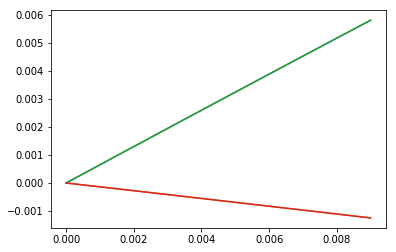

In [119]:
plt.plot([test2_c[i][9] for i in range(test2_c.shape[0])], [test2result[i]["measurement"] for i in range(test2_c.shape[0])] )
plt.plot([test2_c[i][9] for i in range(test2_c.shape[0])], [test2result[i]["measurement"] for i in range(test2_c.shape[0])] )





In [129]:
test3_init = [("gaussian" ,5.0    ,0.28,0.28,"gaussian"  ,2.0+0.5*i  ,{'subtract_intersection':True}) for i in range(20)
]
test3_m = np.zeros(shape = (20,12))
test3_c = np.zeros(shape = (20,12))
for i in range(test3_c.shape[0]):
    test3_c[i][9]+=0.02
    test3_c[i][7]+=0.01
    test3_c[i][11]+=0.01



In [130]:
test3result = []
for i in range(len(test3_m)):
    test = HOMExShapelet(*test3_init[i][:-1],**test3_init[i][-1])
    test.setup_shapelet_psf(test3_m[i],test3_c[i])
    results = test.get_results()
    test3result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test3_m)*100)+"%")

Finished 100.0%


Text(0,0.5,'$\\delta e_1 /$ kurtosis bias')

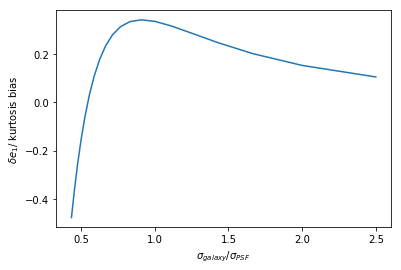

In [137]:
delta_kurtosis = np.sum(test3_c,axis = 1)
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test3result],np.array([ t["measurement"][0] for t in test3result])/delta_kurtosis)
plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
plt.ylabel(r'$\delta e_1 /$ kurtosis bias')

In [8]:
def do_tests(tests,j,test_m, test_c,n):
    testsresult=[]
    for i in range(len(tests)):
        test = HOMExShapelet(*tests[i][:-1],**tests[i][-1])
        test.setup_shapelet_psf(test_m[i],test_c[i],n)
        results = test.get_results(metacal = False)
        testsresult.append(results)
        #clear_output() 
        print ("Finished "+str(float((i+1))/len(tests)*100)+"%")
    return testsresult
    

In [39]:
test4_init = [("gaussian" ,5.0    ,0.28,0.28,"gaussian"  ,2.0+0.5*i  ,{'subtract_intersection':True}) for i in range(20)
]
test4_m = np.zeros(shape = (9,20,12))
test4_c = np.zeros(shape = (9,20,12))
for index in range(9):
    for i in range(20):
        test4_c[index][i][index+3]+=0.01



In [41]:
test4result = []
for i in range(len(test4_m)):
    print "Start tests for moment"+ str(i+4)
    test4result.append(do_tests(test4_init,i,test4_m[i],test4_c[i],4))
    

Start tests for moment4
Finished 5.0%
Finished 10.0%
Finished 15.0%
Finished 20.0%
Finished 25.0%
Finished 30.0%
Finished 35.0%
Finished 40.0%
Finished 45.0%
Finished 50.0%
Finished 55.0%
Finished 60.0%
Finished 65.0%
Finished 70.0%
Finished 75.0%
Finished 80.0%
Finished 85.0%
Finished 90.0%
Finished 95.0%
Finished 100.0%
Start tests for moment5
Finished 5.0%
Finished 10.0%
Finished 15.0%
Finished 20.0%
Finished 25.0%
Finished 30.0%
Finished 35.0%
Finished 40.0%
Finished 45.0%
Finished 50.0%
Finished 55.0%
Finished 60.0%
Finished 65.0%
Finished 70.0%
Finished 75.0%
Finished 80.0%
Finished 85.0%
Finished 90.0%
Finished 95.0%
Finished 100.0%
Start tests for moment6
Finished 5.0%
Finished 10.0%
Finished 15.0%
Finished 20.0%
Finished 25.0%
Finished 30.0%
Finished 35.0%
Finished 40.0%
Finished 45.0%
Finished 50.0%
Finished 55.0%
Finished 60.0%
Finished 65.0%
Finished 70.0%
Finished 75.0%
Finished 80.0%
Finished 85.0%
Finished 90.0%
Finished 95.0%
Finished 100.0%
Start tests for moment7
Fini

In [158]:
print len(test4result[0])

20


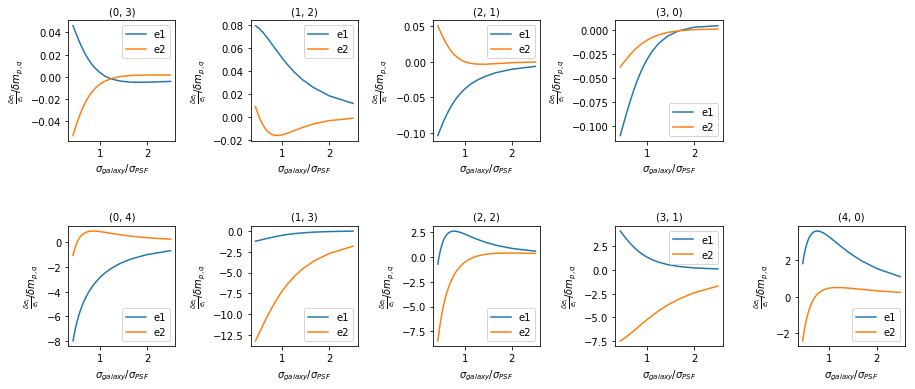

In [43]:
pqlist = test1.sxm.get_pq_full(4)[3:]
fig = plt.figure(figsize = (15,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.7)
for j in range(9):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    ax = plt.subplot(2,5,1+5*(n-3)+p)
    plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test4result[j]],np.array([t["measurement"][0]/t['e1']/0.01 for t in test4result[j]]),label='e1')
    plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test4result[j]],np.array([t["measurement"][1]/t['e2']/0.01 for t in test4result[j]]),label='e2')
    
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    
    plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
    plt.ylabel(r'$\frac{\delta e_i}{e_i} / \delta m_{p,q}$')
    
    plt.title(str((p,q)))
    #plt.show()
    plt.legend()
    
#fig.colorbar(axes)

In [2]:
pqlist

NameError: name 'pqlist' is not defined

In [165]:
test5_init = [("gaussian" ,5.0    ,0.28,0.28,"gaussian"  ,2.0+0.5*i  ,{'subtract_intersection':True}) for i in range(20)
]
test5_m = np.zeros(shape = (20,12))
test5_c = np.zeros(shape = (20,12))
for i in range(test5_c.shape[0]):
    test5_c[i][6]+=0.01
    test5_c[i][4]+=0.01



In [166]:
test5result = []
for i in range(len(test5_m)):
    test = HOMExShapelet(*test5_init[i][:-1],**test5_init[i][-1])
    test.setup_shapelet_psf(test5_m[i],test5_c[i])
    results = test.get_results()
    test5result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test5_m)*100)+"%")

Finished 100.0%


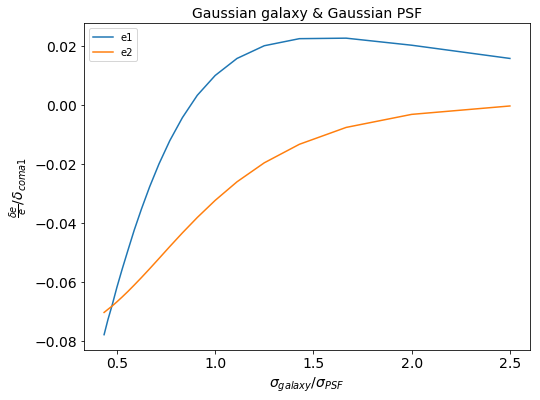

In [196]:
plt.figure(figsize = (8,6))
delta_kurtosis = np.sum(test5_c,axis = 1)
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test5result],np.array([ t["measurement"][0]/t['e1']/0.02 for t in test5result]),label = 'e1')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test5result],np.array([ t["measurement"][1]/t['e1']/0.02 for t in test5result]),label = 'e2')

plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
plt.ylabel(r'$\frac{\delta e}{e} / \delta_{coma1}$')

plt.title('Gaussian galaxy & Gaussian PSF')
plt.legend()

In [168]:
test6_init = [("gaussian" ,5.0    ,0.28,0.28,"gaussian"  ,2.0+0.5*i  ,{'subtract_intersection':True}) for i in range(20)
]
test6_m = np.zeros(shape = (20,12))
test6_c = np.zeros(shape = (20,12))
for i in range(test6_c.shape[0]):
    test6_c[i][3]+=0.01
    test6_c[i][5]+=0.01



In [169]:
test6result = []
for i in range(len(test6_m)):
    test = HOMExShapelet(*test6_init[i][:-1],**test6_init[i][-1])
    test.setup_shapelet_psf(test6_m[i],test6_c[i])
    results = test.get_results()
    test6result.append(results)
    clear_output()
    print ("Finished "+str(float((i+1))/len(test6_m)*100)+"%")

Finished 100.0%


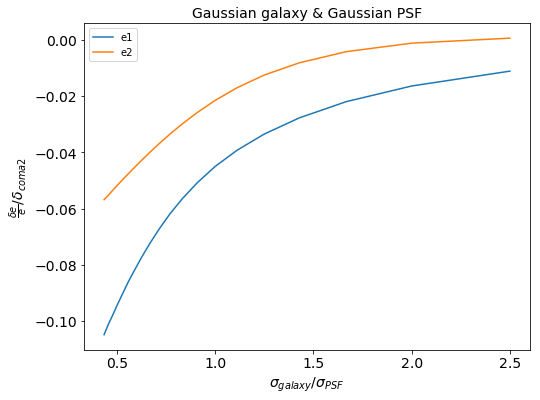

In [197]:
plt.figure(figsize = (8,6))

delta_kurtosis = np.sum(test6_c,axis = 1)
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test6result],np.array([ t["measurement"][0]/t['e1']/0.02 for t in test6result]),label = 'e1')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test6result],np.array([ t["measurement"][1]/t['e2']/0.02 for t in test6result]),label = 'e2')

plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
plt.ylabel(r'$\frac{\delta e}{e} / \delta_{coma2}$')

plt.title('Gaussian galaxy & Gaussian PSF')

plt.legend()

In [202]:
test7_init = [("gaussian" ,5.0    ,0.28,0.28,"gaussian"  ,2.0+0.5*i  ,{'subtract_intersection':True}) for i in range(20)
]
test7_m = np.zeros(shape = (20,12))
test7_c = np.zeros(shape = (20,12))
for i in range(test7_c.shape[0]):
    test7_c[i][6]+=0.01
    test7_c[i][4]-=0.03



In [204]:
test7result = []
for i in range(len(test7_m)):
    test = HOMExShapelet(*test7_init[i][:-1],**test7_init[i][-1])
    test.setup_shapelet_psf(test7_m[i],test7_c[i])
    results = test.get_results()
    test7result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test7_m)*100)+"%")

Finished 100.0%


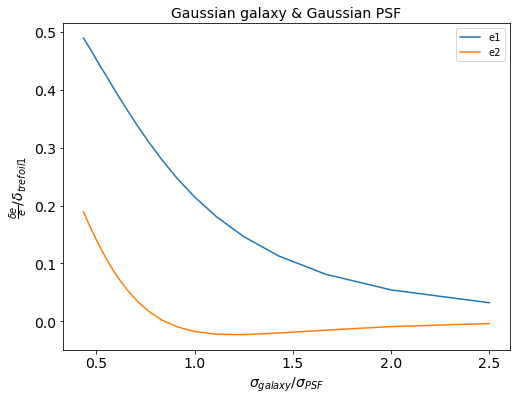

In [208]:
plt.figure(figsize = (8,6))

plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test7result],np.array([ t["measurement"][0]/t['e1']/0.02 for t in test7result]),label = 'e1')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test7result],np.array([ t["measurement"][1]/t['e2']/0.02 for t in test7result]),label = 'e2')

plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
plt.ylabel(r'$\frac{\delta e}{e} / \delta_{trefoil1}$')

plt.title('Gaussian galaxy & Gaussian PSF')

plt.legend()

In [205]:
test8_init = [("gaussian" ,5.0    ,0.28,0.28,"gaussian"  ,2.0+0.5*i  ,{'subtract_intersection':True}) for i in range(20)
]
test8_m = np.zeros(shape = (20,12))
test8_c = np.zeros(shape = (20,12))
for i in range(test8_c.shape[0]):
    test8_c[i][3]+=0.03
    test8_c[i][5]-=0.01



In [206]:
test8result = []
for i in range(len(test8_m)):
    test = HOMExShapelet(*test8_init[i][:-1],**test8_init[i][-1])
    test.setup_shapelet_psf(test8_m[i],test8_c[i])
    results = test.get_results()
    test8result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test8_m)*100)+"%")

Finished 100.0%


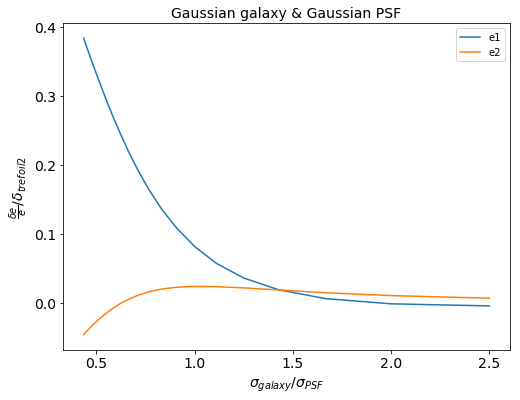

In [207]:
plt.figure(figsize = (8,6))

plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test8result],np.array([ t["measurement"][0]/t['e1']/0.02 for t in test8result]),label = 'e1')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test8result],np.array([ t["measurement"][1]/t['e2']/0.02 for t in test8result]),label = 'e2')

plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
plt.ylabel(r'$\frac{\delta e}{e} / \delta_{trefoil2}$')

plt.title('Gaussian galaxy & Gaussian PSF')

plt.legend()

In [24]:
test9_init = [("gaussian" ,5.0    ,0.28,0.28,"gaussian"  ,2.0+0.5*i  ,{'subtract_intersection':True}) for i in range(20)
]
test9_m = np.zeros(shape = (13,20,25))
test9_c = np.zeros(shape = (13,20,25))
for index in range(13):
    for i in range(20):
        test9_c[index][i][index+12]+=0.01



In [25]:
test9result = []
for i in range(len(test9_m)):
    print "Start tests for moment"+ str(i+13)
    test9result.append(do_tests(test9_init,i,test9_m[i],test9_c[i],6))
    

Start tests for moment13
Finished 5.0%
Finished 10.0%
Finished 15.0%
Finished 20.0%
Finished 25.0%
Finished 30.0%
Finished 35.0%
Finished 40.0%
Finished 45.0%
Finished 50.0%
Finished 55.0%
Finished 60.0%
Finished 65.0%
Finished 70.0%
Finished 75.0%
Finished 80.0%
Finished 85.0%
Finished 90.0%
Finished 95.0%
Finished 100.0%
Start tests for moment14
Finished 5.0%
Finished 10.0%
Finished 15.0%
Finished 20.0%
Finished 25.0%
Finished 30.0%
Finished 35.0%
Finished 40.0%
Finished 45.0%
Finished 50.0%
Finished 55.0%
Finished 60.0%
Finished 65.0%
Finished 70.0%
Finished 75.0%
Finished 80.0%
Finished 85.0%
Finished 90.0%
Finished 95.0%
Finished 100.0%
Start tests for moment15
Finished 5.0%
Finished 10.0%
Finished 15.0%
Finished 20.0%
Finished 25.0%
Finished 30.0%
Finished 35.0%
Finished 40.0%
Finished 45.0%
Finished 50.0%
Finished 55.0%
Finished 60.0%
Finished 65.0%
Finished 70.0%
Finished 75.0%
Finished 80.0%
Finished 85.0%
Finished 90.0%
Finished 95.0%
Finished 100.0%
Start tests for moment16


0 5
1 4
2 3
3 2
4 1
5 0
0 6
1 5
2 4
3 3
4 2
5 1
6 0


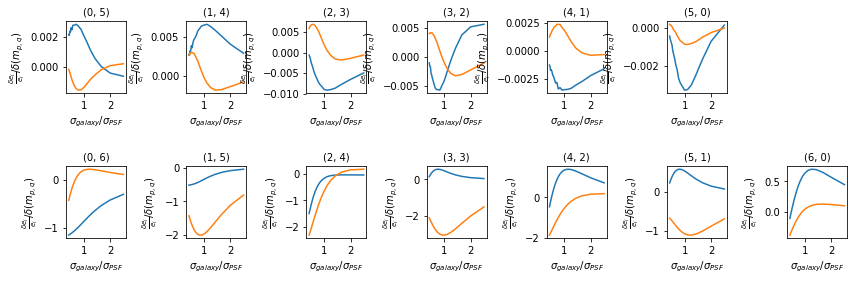

In [38]:
pqlist = test1.sxm.get_pq_full(6)[12:]
fig = plt.figure(figsize = (14,4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.0, hspace=1.0)
for j in range(13):
    p,q = pqlist[j][0],pqlist[j][1]
    n = p+q
    print p,q
    ax = plt.subplot(2,7,1+7*(n-5)+p)
    plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test9result[j]],np.array([t["measurement"][0]/t['e1']/0.01 for t in test9result[j]]),label='e1')
    plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test9result[j]],np.array([t["measurement"][1]/t['e2']/0.01 for t in test9result[j]]),label='e2')
    
    #print test4_gaussian_results[j][0]['psf_bvec'][:15]/test4_gaussian_results[j][0]['psf_bvec'][0]
    
    plt.xlabel(r"$\sigma_{galaxy}/\sigma_{PSF}$")
    plt.ylabel(r'$\frac{\delta e_i}{e_i} / \delta(m_{p,q})$')
    
    plt.title(str((p,q)))
    #plt.show()
    #plt.legend()
    
#fig.colorbar(axes)